In [1]:
# Import required libraries
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read and prepare the data
df = pd.read_csv('FloodPrediction.csv')
# Handle missing values (NaN)
df['Flood?'] = df['Flood?'].fillna(0)  # Replace NaN with 0 in Flood? column

In [3]:
# Standardize the features
features_to_scale = ['Rainfall', 'Max_Temp', 'Min_Temp', 'Relative_Humidity']
df_scaled = df.copy()
df_scaled[features_to_scale] = (df[features_to_scale] - df[features_to_scale].mean()) / df[features_to_scale].std()


In [4]:
# Define the basic Bayesian model
with pm.Model() as flood_model:
    # Priors for unknown model parameters
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    
    # Coefficients for predictors
    beta_rainfall = pm.Normal('beta_rainfall', mu=0, sigma=2)
    beta_maxtemp = pm.Normal('beta_maxtemp', mu=0, sigma=2)
    beta_mintemp = pm.Normal('beta_mintemp', mu=0, sigma=2)
    beta_humidity = pm.Normal('beta_humidity', mu=0, sigma=2)
    
    # Expected value of outcome
    mu = intercept + (beta_rainfall * df_scaled['Rainfall'] + 
                     beta_maxtemp * df_scaled['Max_Temp'] + 
                     beta_mintemp * df_scaled['Min_Temp'] + 
                     beta_humidity * df_scaled['Relative_Humidity'])
    
    # Likelihood (sampling distribution) of observations
    y = pm.Bernoulli('y', logit_p=mu, observed=df['Flood?'])
    
    # Inference
    idata = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_rainfall, beta_maxtemp, beta_mintemp, beta_humidity]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 120 seconds.


In [5]:
# Model evaluation
summary = az.summary(idata)
print("\nModel Summary:")
print(summary)


Model Summary:
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept     -4.208  0.126  -4.451   -3.982      0.002    0.001    4318.0   
beta_rainfall  3.987  0.084   3.831    4.145      0.001    0.001    5944.0   
beta_maxtemp  -0.029  0.066  -0.147    0.100      0.001    0.001    5366.0   
beta_mintemp   1.102  0.146   0.831    1.377      0.002    0.002    4082.0   
beta_humidity  0.408  0.088   0.243    0.574      0.001    0.001    4564.0   

               ess_tail  r_hat  
intercept        4231.0    1.0  
beta_rainfall    5166.0    1.0  
beta_maxtemp     5469.0    1.0  
beta_mintemp     4814.0    1.0  
beta_humidity    5167.0    1.0  


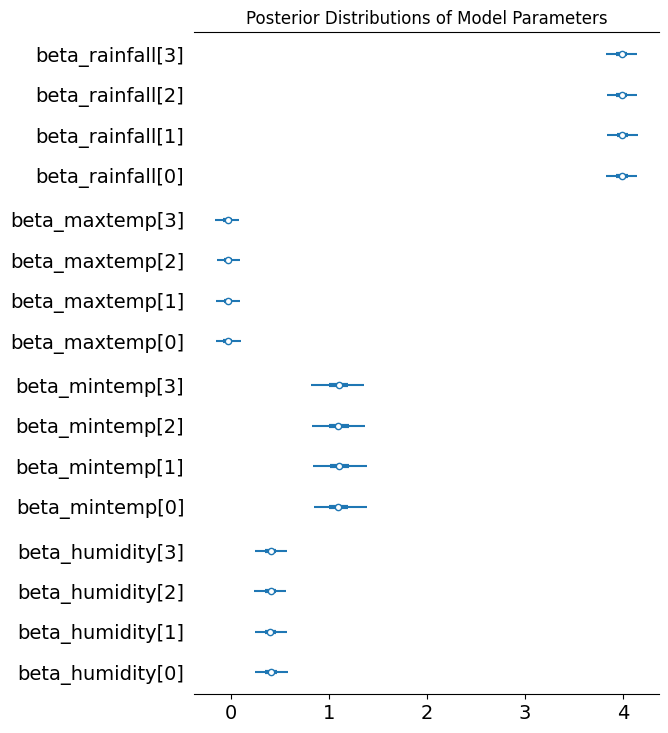

In [6]:
# Plot the posterior distributions
az.plot_forest(idata, var_names=['beta_rainfall', 'beta_maxtemp', 'beta_mintemp', 'beta_humidity'])
plt.title('Posterior Distributions of Model Parameters')
plt.show()

In [7]:
# Calculate feature importance
feature_importance = pd.DataFrame({
    'Feature': features_to_scale,
    'Importance': np.abs([
        summary.loc['beta_rainfall', 'mean'],
        summary.loc['beta_maxtemp', 'mean'],
        summary.loc['beta_mintemp', 'mean'],
        summary.loc['beta_humidity', 'mean']
    ])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
             Feature  Importance
0           Rainfall       3.987
2           Min_Temp       1.102
3  Relative_Humidity       0.408
1           Max_Temp       0.029


In [8]:
# Posterior predictive checks
with flood_model:
    posterior_pred = pm.sample_posterior_predictive(idata)


Sampling: [y]


In [9]:
# Calculate prediction probabilities
y_pred = posterior_pred.posterior_predictive.y.mean(dim=("chain", "draw")) > 0.5
accuracy = (y_pred == df['Flood?']).mean()
print(f"\nModel Accuracy: {accuracy:.2f}")


Model Accuracy: 0.94


In [10]:
# Check class distribution
print("Class Distribution:")
print(df['Flood?'].value_counts(normalize=True))

Class Distribution:
Flood?
0.0    0.798871
1.0    0.201129
Name: proportion, dtype: float64
